## ЛАБОРАТОРНАЯ РАБОТА ИТОГОВАЯ
## Статистическая обработка данных психологического исследования
#### по дисциплине «Математическая статистика»
Направление подготовки 01.03.02 Прикладная математика и информатика
Очной формы обучения

выполнил: студент группы Б9123-01.03.02ии

Иванов Матвей Олегович

принял: Деревягин Андрей Алексеевич

# Математическая часть

### Тест Шапиро-Уилка
Тест Шапиро-Уилка — это проверка гипотез, которая применяется к выборке данных с нулевой
гипотезой о том, что выборка имеет нормальное распределение. В этом тесте высокое значение p
указывает на то, что набор данных имеет нормальное распределение, тогда как низкое значение p
указывает на то, что он не имеет нормального распределения.

### Критерий Колмогорова

Критерий Колмогорова - Проверка гипотезы о том, что cлучайная выборка $X_1, …, X_n​$ \
c распределением F_x(x) происходит из заданного распределения $\hat{F}(x)$

статистика $D_n = \sqrt{n} \cdot sup_{x \in R} |\hat{F}(x) - F_x(x)|$ \
Асимптотическое распределение статистики $\sqrt{n}D_n$ при $n \to \infty$ задаётся функцией Колмогорова: \
$F_k(x) = \sum_{k=-\infty}^{+\infty} (-1)^k e^{-2k^2x^2} \cdot I(x > 0)$ \
p-значение $p = 1 - F_K(k)$



### Корреляция пирсона
это метод, позволяющий оценить линейную зависимость между двумя количественными переменными.

# листинг кода

## подготовка

In [12]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
DATA_PATH = "/home/matv864/it/AI_work/data/psydata.xlsx"
SIGNIFICANCE_LEVEL = 0.01

In [14]:
# заголовки убрал вручную
socio = pd.read_excel(DATA_PATH, sheet_name='Социофобия')
attach = pd.read_excel(DATA_PATH, sheet_name='ПривязанностьМ')
anxiety = pd.read_excel(DATA_PATH, sheet_name='Тревожность')
negative = pd.read_excel(DATA_PATH, sheet_name='Негатив')
fears = pd.read_excel(DATA_PATH, sheet_name='Страхи')

In [15]:
data = pd.DataFrame({'idВ отчёте записать гипотезы формально. Всё использовать библиотечное. Использовать желательно изученные на курсе критерии.': socio['id']})

data['социалочка'] = socio['Общий']

data['надёжная привязанность'] = attach['н']
data['тревожная привязанность'] = attach['т']
data['избегающая привязанность'] = attach['и']

data['общая тревожность'] = anxiety['Общая']
data['школьная тревожность'] = anxiety['Школьная']
data['самооценочная тревожность'] = anxiety['Самооценочная']
data['межличностная тревожность'] = anxiety['Межличностная']

data['страх негативной оценки'] = negative['Сумма']
data['сумма всех страхов из таблицы страхов'] = fears['Сумма']
data['общий бал страхов'] = data['страх негативной оценки'] + data['сумма всех страхов из таблицы страхов']





## тесты и инструменты

In [16]:
# проверка на нормальность через тесты Шапиро-Уилка и Колмогорова-Смирнова
def check_normality(*groups):
    results = []
    for group in groups:
        stat, p_val = stats.shapiro(group)
        results.append(p_val > SIGNIFICANCE_LEVEL)

    if all(results):
        return True
    
    # тест Шапиро-Уилка чувствителен к выбросам, поэтому проверяем более универсальным тестом Колмогорова-Смирнова
    
    results = []
    for group in groups:
        ks_stat, ks_p_val = stats.kstest(group, 'norm', args=(np.mean(group), np.std(group)))
        results.append(ks_p_val > SIGNIFICANCE_LEVEL)

    return all(results)

In [17]:
def compare_groups(column: str):
    """
    return
    normal: bool
    p_value (middle of unrel attach > middle of rel attach): float
    """
    unrel = data[data['надёжная привязанность'] > 5][column].dropna()  # X - среднее ненадёжной группы
    rel = data[data['надёжная привязанность'] <= 5][column].dropna()      # Y - среднее надёжной группы

    normal = check_normality(unrel, rel)
    stat, p = stats.ttest_ind(unrel, rel, alternative='greater')
    return normal, p


In [18]:
def count_important_correlations(df, target_col, fear_cols):
    result = 0
    for col in fear_cols:
        r_value, p_value = stats.pearsonr(df[target_col], df[col])
        if p_value < SIGNIFICANCE_LEVEL:
            result += 1
    return result

In [19]:
def plot_correlation_heatmap(group, title):
    """Строит heatmap корреляций между общей тревожностью и страхами"""
    fear_columns = ['Животные', 'Темнота', 'Сумасшествие', 'Болезнь близких',
                    'Преступность', 'Начальство', 'Изменений', 'Ответственность',
                    'Старость', 'Сердце', 'Бедность', 'Будущее', 'Экзамены', 'Война',
                    'Смерть', 'Замкнутые пространства', 'Высота', 'Глубина', 'Негативные последствия болезни близких',
                    'Заболеть', 'Самоубийство', 'Публичные выступления', 'Агрессия к близким']

    fear_columns_with_anxiety = ['Общая'] + fear_columns
    corr_data = group[fear_columns_with_anxiety]
    correlation_matrix = corr_data.corr(method='spearman')

    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## задание 1,2,3,4

In [20]:
levels = [
    # 1 задание
    "социалочка",

    # 2 задание
    "общая тревожность",
    "школьная тревожность",
    "самооценочная тревожность",
    "межличностная тревожность",

    # 3 задание
    "страх негативной оценки",
    
    # 4 задание
    "общий бал страхов",
]

for level in levels:
    print(level)
    normal, p_val = compare_groups(level)

    if not normal:
        print("Нормальность не подтверждена, результаты t-теста стоит воспринимать осторожно")

    if p_val < 0.05:
        print(f"H_1 подтверждена — среднее значение уровня '{level}' ненадёжно привязанных выше, чем надёжно привязанных")
    else:
        print(f"H_0 не отвергается — нет доказательств, что среднее значение уровня '{level}' ненадёжно привязанных выше, чем надёжно привязанных")
    print("-"*100)


социалочка
H_0 не отвергается — нет доказательств, что среднее значение уровня 'социалочка' ненадёжно привязанных выше, чем надёжно привязанных
----------------------------------------------------------------------------------------------------
общая тревожность
H_0 не отвергается — нет доказательств, что среднее значение уровня 'общая тревожность' ненадёжно привязанных выше, чем надёжно привязанных
----------------------------------------------------------------------------------------------------
школьная тревожность
H_0 не отвергается — нет доказательств, что среднее значение уровня 'школьная тревожность' ненадёжно привязанных выше, чем надёжно привязанных
----------------------------------------------------------------------------------------------------
самооценочная тревожность
H_0 не отвергается — нет доказательств, что среднее значение уровня 'самооценочная тревожность' ненадёжно привязанных выше, чем надёжно привязанных
---------------------------------------------------------

## задание 5


In [21]:
data = pd.merge(anxiety[['id', 'Общая']], fears.drop(columns=['Сумма']), on='id')
data = pd.merge(data, attach[['id', 'н']], on='id')

rel = data[data['н'] > 5]
unrel = data[data['н'] <= 5]



# Столбцы страхов (исключаем 'id', 'Общая', 'н')
fear_cols = ['Животные', 'Темнота', 'Сумасшествие', 'Болезнь близких', 'Преступность', 'Начальство', 'Изменений', 'Ответственность', 'Старость', 'Сердце', 'Бедность', 'Будущее', 'Экзамены', 'Война', 'Смерть', 'Замкнутые пространства', 'Высота', 'Глубина', 'Негативные последствия болезни близких', 'Заболеть', 'Самоубийство', 'Публичные выступления', 'Агрессия к близким']
rel_count = count_important_correlations(rel, 'Общая', fear_cols)
unrel_count = count_important_correlations(unrel, 'Общая', fear_cols)

# Вывод результата
print(f"Надёжно привязанные: {rel_count} значимых корреляций")
print(f"Ненадёжно привязанные: {unrel_count} значимых корреляций")


Надёжно привязанные: 11 значимых корреляций
Ненадёжно привязанные: 19 значимых корреляций


## тепловая карта корреляций

Heatmap для надежно привязанных:


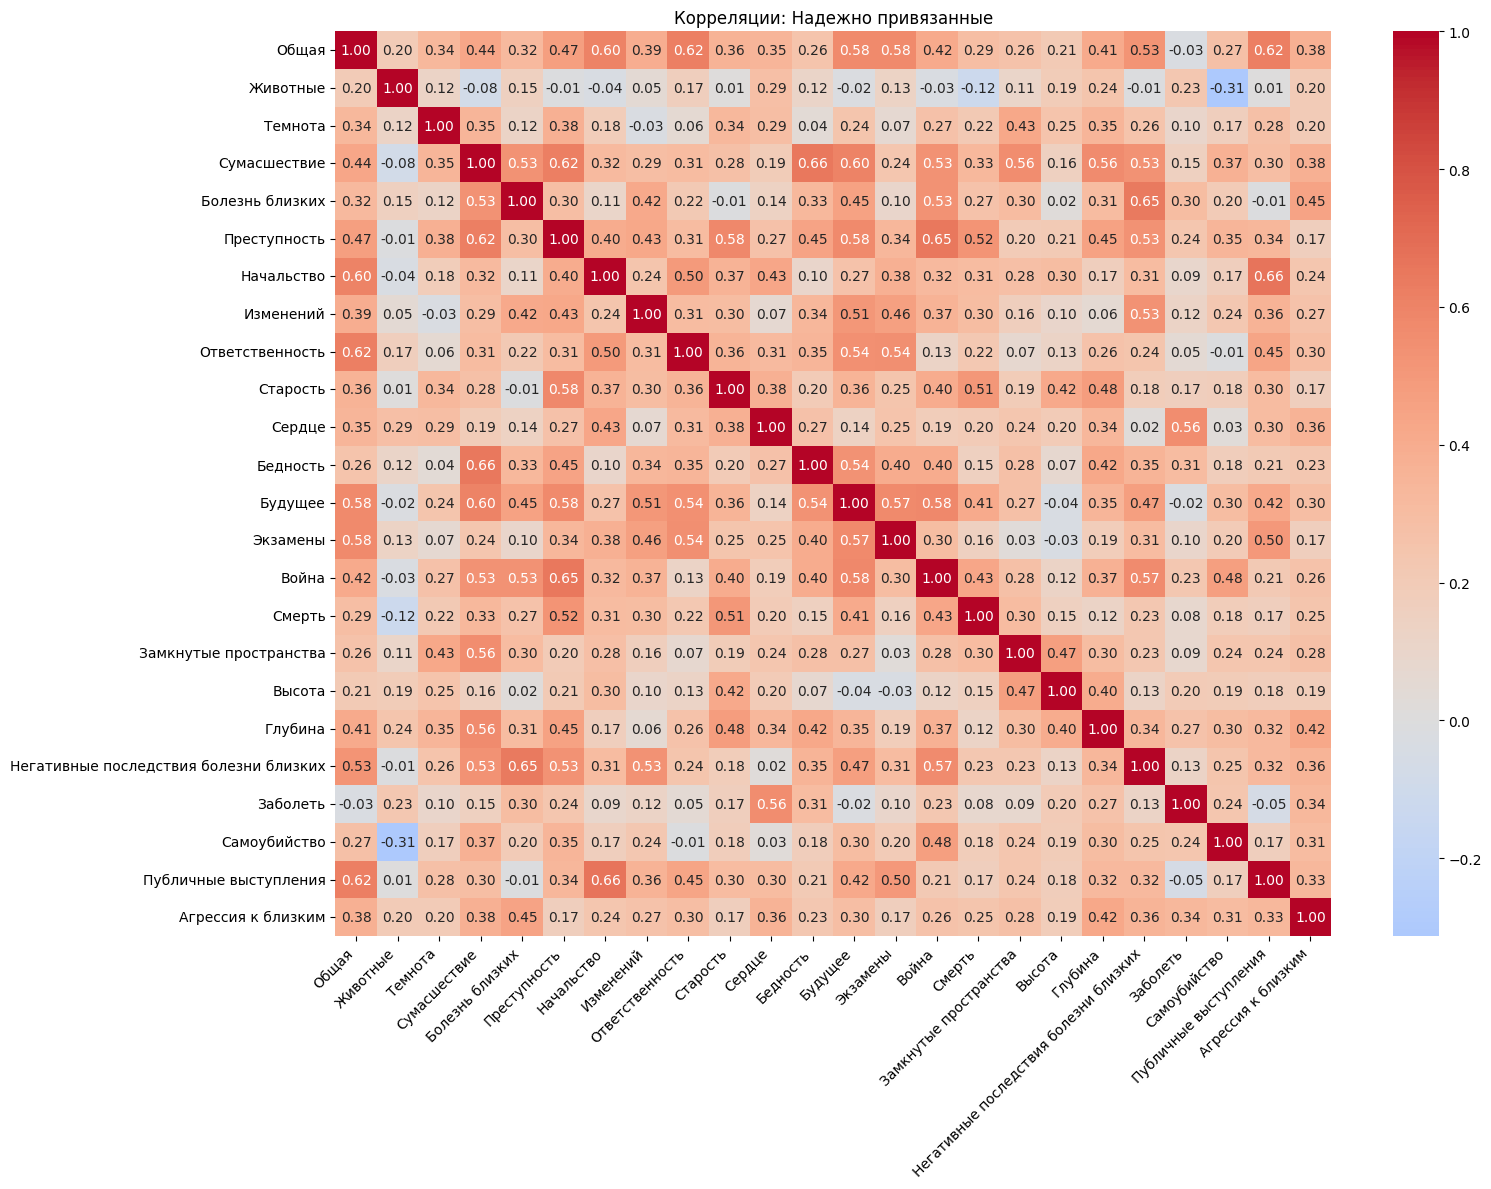

Heatmap для ненадежно привязанных:


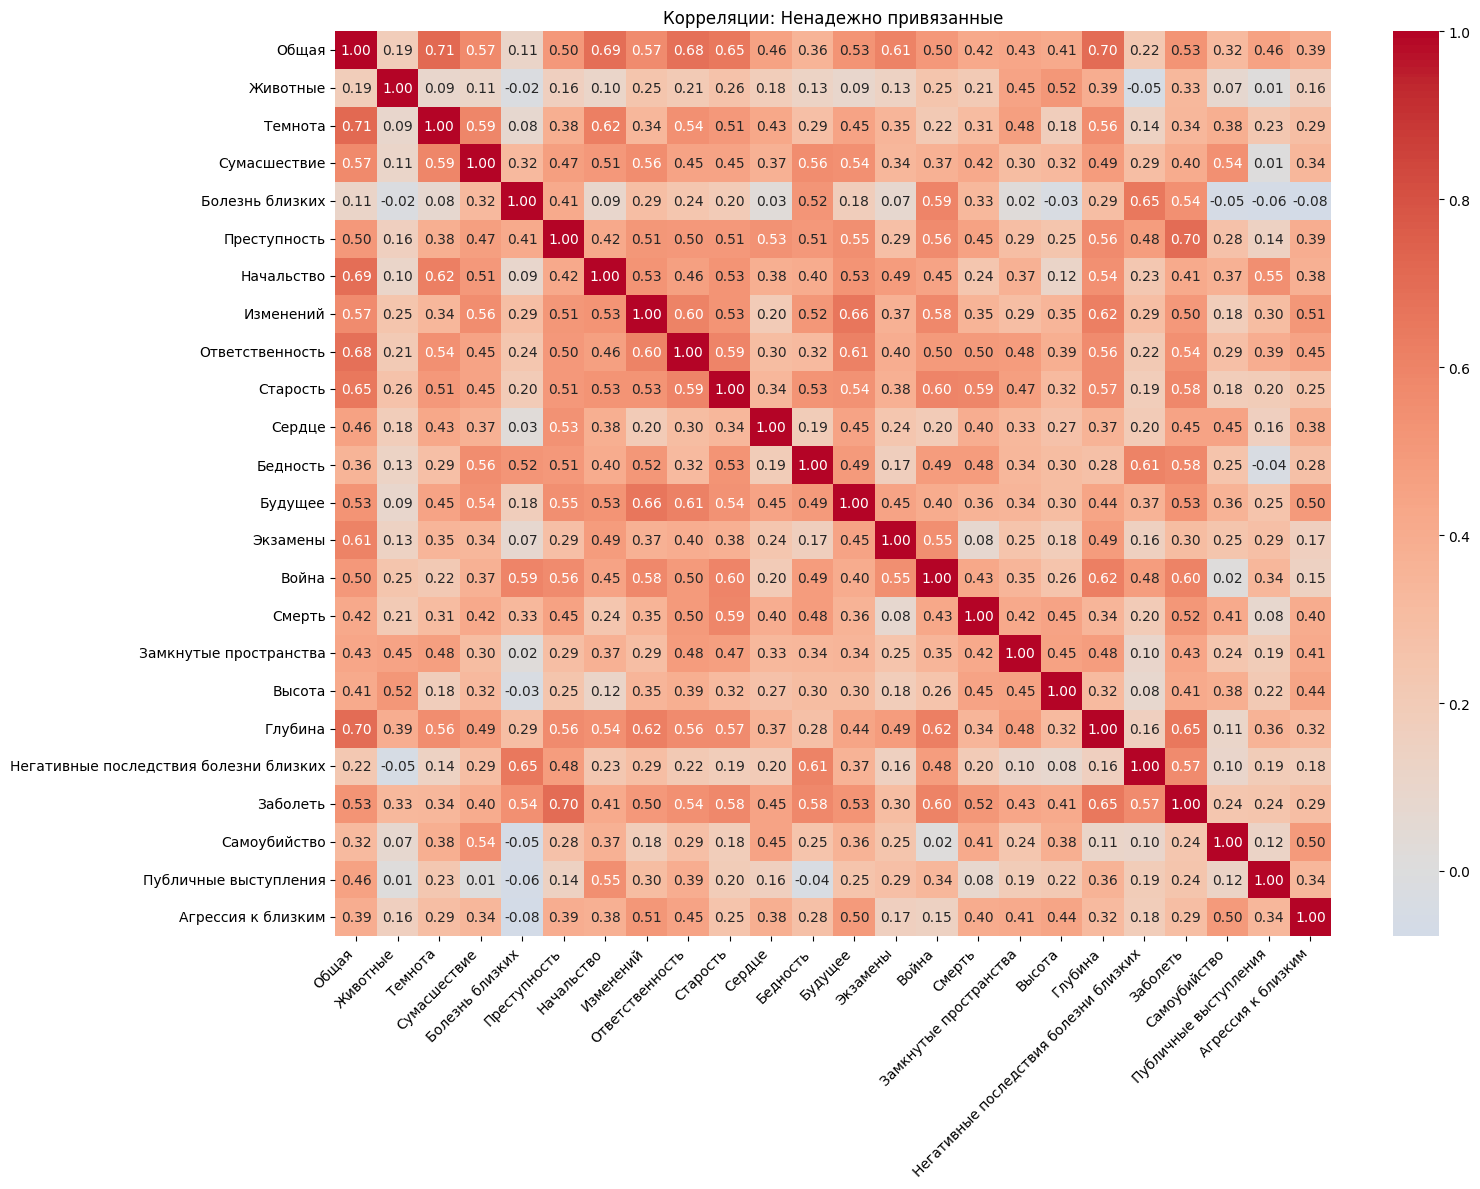

In [22]:
print("Heatmap для надежно привязанных:")
plot_correlation_heatmap(rel, "Корреляции: Надежно привязанные")

print("Heatmap для ненадежно привязанных:")
plot_correlation_heatmap(unrel, "Корреляции: Ненадежно привязанные")

Все обновления и историю изменений можно посмотреть по ссылке в моём репозитории \
https://github.com/matv864/AI_work/tree/main/matstat